In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('punkt')

from nltk.stem.porter import PorterStemmer
stemmer= PorterStemmer() # create the instance

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.sentiment import SentimentIntensityAnalyzer
SIA= SentimentIntensityAnalyzer() # create the instance

[nltk_data] Downloading package punkt to C:\Users\hchih...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\hchih...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# get dialogue dataframe
def get_dialogue(script):
    raw= []
#     print(file_name)
    if '#' in script[0]:
        for n, para in enumerate(script):
                if '#' in para: pass
                else: raw.append(para)                    
    else: 
        for n, para in enumerate(script):
                dp= []
                for i, ele in enumerate(para):
                    if ele== '[': 
                            dp.append(i-1) 
                    elif ele== ']': 
                            dp.append(i+2)
                if (len(dp)== 0):
                    if len(para)== 1: # no content no [] 
                        pass
                    else: 
                        raw.append(para) # content with no [] 
                elif (len(dp)!= 0) and (dp[0]== -1):
                    pass
                else:
                    for i in range(len(dp), 0, -2):
                        para= para.replace(para[dp[i-2]:dp[i-1]-1],' ')
                    raw.append(para)
    return file_name, raw

In [3]:
# turn to dataframe 
def to_df(scripts):    
    # seperate character & lines, save to dataframe
    mv_lst= []
    chct_lst= []
    ln_lst=[]    
    for idx, script in enumerate(scripts):
            for i, para in enumerate(scripts[idx][1]):
                para= para.lower().replace('\n',' ')
                if len(para.split(':'))== 2:
                    chct= para.split(':', 1)[0]
                    chct_lst.append(chct)
                    line= para.split(':', 1)[1]
                    ln_lst.append(line)
                    mv_lst.append(scripts[idx][0][:-11])
    df= pd.concat([pd.DataFrame({'Movie': mv_lst,'Character': chct_lst,'Line': ln_lst})], axis= 1)
    
    # name integration
    df['Character'].replace({'iron man': 'tony stark', 'tony': 'tony stark',
                    'natasha': 'natasha romanoff', 'black widow': 'natasha romanoff', 
                    'captain america': 'steve rogers', 'steve': 'steve rogers',
                    'james barnes': 'bucky barnes', 'winter soldier': 'bucky barnes', 
                    'hawkeye': 'clint barton', 'clint': 'clint barton',
                    'bruce': 'bruce banner', 'hulk': 'bruce banner', 'banner': 'bruce banner',
                    't\'challa': 'black panther',
                    'fury': 'nick fury',
                    'peter parker': 'spider man', 'rocket raccoon': 'rocket',
                    'scott': 'scott lang', 
                    'carol': 'captain marvel',
                    'dr. strange': 'dr strange', 'dr. stephen strange': 'dr strange', 'doctor stephen strange': 'dr strange', 'doctor strange': 'dr strange',
                    'pepper': 'pepper potts',
                    'dr. hank pym': 'hank',
                    'hope van dyne': 'hope',
                    'quill': 'peter quill',
                    'colonel james rhodes': 'james rhodes', 'rhodey': 'james rhodes',
                    'jane foster': 'jane'
                         }, inplace= True)
    return df

In [4]:
# clean dialogue with nltk
def get_cleandf(df):
    tknzr= RegexpTokenizer('\w+')

    # tokenize & count
    df.insert(3, column='Line Count', value= df['Line'].apply(lambda para: len(sent_tokenize(para)) ))
    df.insert(4, column='Word Count', value= df['Line'].apply(lambda para: len(para.split())))
    df.insert(5, column='Line Clean', value= df['Line'].apply(lambda para: ' '.join(sent_tokenize(para))))
   
    # remove punctuation, remove stopword, stem
    df['Line Clean']= df['Line Clean'].apply(lambda para: ' '.join(tknzr.tokenize(para)))\
    .apply(lambda para: ' '.join(word for word in para.split() if word not in stopwords.words('english')))\
    .apply(lambda para: ' '.join(stemmer.stem(word) for word in para.split()))
    
    df.insert(6, column="Sentiment Score", value= df['Line Clean'].apply(lambda sent: SIA.polarity_scores(sent)['compound']))

    return df

In [5]:
# set main characters statistics and generate plot
def to_plot(df):
    global main_char
    mvchar_group= df[df['Character'].isin(main_char)].groupby('Character')
    
    # line vs word count plot
    tmpdf= mvchar_group[['Line Count', 'Word Count']].sum().sort_values(by= 'Word Count', ascending= False)   
    fig1, ax4= plt.subplots(figsize= (8, 6))
    ax5= ax4.twinx()
    ax4.bar(tmpdf.index, tmpdf['Line Count'], color= 'gold', label= 'Line Count')
    ax5.plot(tmpdf.index, tmpdf['Word Count'], color= 'green')
    ax4.set_xticklabels(tmpdf.index, rotation= 90)
    ax4.legend(loc='best')
    plt.title('Line & Word Count of Main Character')
    
    # line/word count & sentiment plot
    fig, (ax, ax2, ax3)= plt.subplots(nrows=3, ncols=1, figsize= (10, 18))
    mvchar_group['Line Count'].sum().sort_values().plot\
    (kind='barh', title= 'Line Count of Main Character', color= 'gold', ax= ax)
    mvchar_group['Word Count'].sum().sort_values().plot\
    (kind='barh', title= 'Word Count of Main Character', color= 'aquamarine', ax= ax2)
    mvchar_group['Sentiment Score'].mean().sort_values().\
    plot(kind='barh', title= 'Avarage Sentiment of Main Character', color= 'lightblue', ax= ax3)
    fig.tight_layout() # adjust subplot automatically   
    
    plt.show()

In [6]:
# generate average word plot
def avg_plot(df):
    global main_char
    mvchar_group= df[df['Character'].isin(main_char)].groupby('Character')
    # character's average words per movie 
    mv_df= mvchar_group['Movie'].nunique()
    sort_df= mvchar_group[['Character', 'Word Count']].sum()
    mg_df= pd.merge(mv_df, sort_df, on= 'Character')
    mg_df['Avg Word Per Movie']= mg_df['Word Count']/ mg_df['Movie']
    mg_df.sort_values(by= 'Movie', ascending= False, inplace= True)
    
    # line vs word count plot
    fig, ax= plt.subplots(figsize= (8, 6))
    ax1= ax.twinx()
    ax.bar(mg_df.index, mg_df['Avg Word Per Movie'], color= 'gold', label= 'Avg Words/ Movie')
    ax1.plot(mg_df.index, mg_df['Movie'], color= 'green')
    ax.set_xticklabels(mg_df.index, rotation= 90)
    ax.legend(loc='best')
    plt.title('Average Word Count')
    plt.show()    
    
    return mg_df

In [7]:
# generate wordcloud
def to_cloud(df, word_num):
    global main_char
    for idx, char in enumerate(main_char):
            print(char)    
            txt= ''
            for lines in df[df['Character']== char]['Line Clean']:
                tmp= lines+ ' '
                txt+= tmp
            
            # to wordcloud
            cloud= WordCloud(width=600, height=300, max_words= word_num,
#                             background_color= 'white',
#                              mode= 'RGBA', background_color= None, # transparent
                             min_font_size = 10,
                            ).generate(txt)
            plt.imshow(cloud)
            plt.axis('off')
            plt.show()                   
#             cloud.to_file(str(char)+ '_max'+ str(word_num)+ '.png')  # save pic    
            print('--------------')

In [8]:
files= os.listdir('../python ntlk movie script')
raw_scripts= []
for i, file_name in enumerate(files):         
        if file_name.endswith(".txt"):
            f= open(file_name, encoding= 'UTF-8-sig')
            script= f.readlines()
            raw_scripts.append(get_dialogue(script)) # append each script   
            f.close()

rawdf= to_df(raw_scripts)
cleandf= get_cleandf(rawdf)
cleandf.head(10)

,Movie,Character,Line,Line Count,Word Count,Line Clean,Sentiment Score
0,ant_man,hank,stark.,1,1,stark,0.0000
1,ant_man,mitchell carson,he doesn’t seem happy.,1,4,seem happi,0.0000
2,ant_man,howard stark,"hello, hank. you’re supposed to be in moscow.",2,8,hello hank suppos moscow,0.0000
3,ant_man,hank,i took a detour. through your defense lab.,2,8,took detour defens lab,0.0000
4,ant_man,peggy carter,tell me that isn’t what i think it is.,1,9,tell think,0.0000
5,ant_man,hank,"it depends, if you think it’s a poor attempt ...",2,20,depend think poor attempt replic work even gro...,-0.4767
6,ant_man,mitchell carson,you were instructed to go to russia. may i re...,2,17,instruct go russia may remind dr pym soldier,0.0000
7,ant_man,hank,i’m a scientist.,1,3,scientist,0.0000
8,ant_man,howard stark,then act like one. the pym particle is the mo...,2,21,act like one pym particl revolutionari scienc ...,0.7964
9,ant_man,hank,"i let you turn me into your errand boy, and n...",1,17,let turn errand boy tri steal research,-0.4939


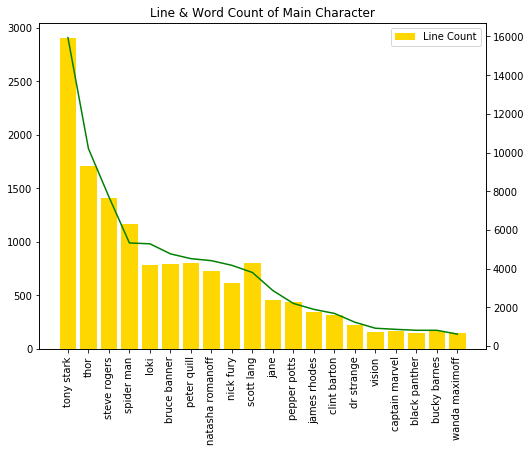

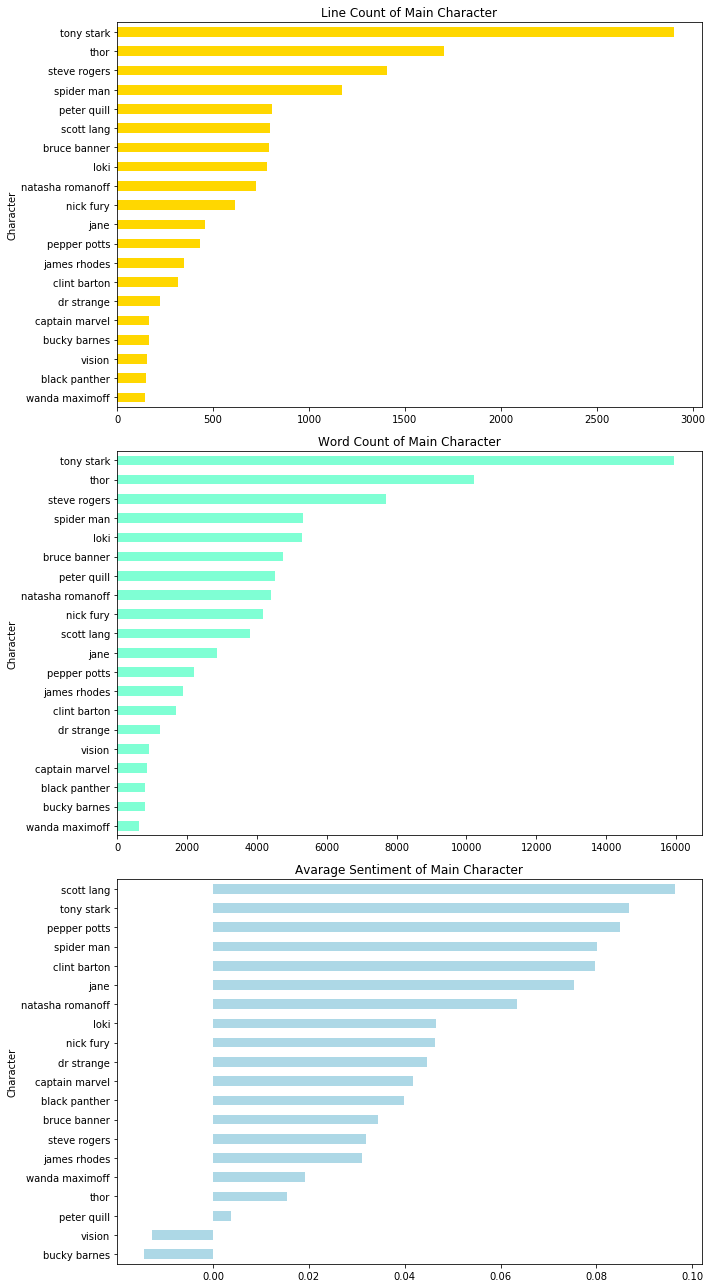

In [9]:
main_char= ['tony stark', 'natasha romanoff', 'thor', 'loki', 'steve rogers', 'clint barton',\
                 'bruce banner','black panther', 'spider man', 'scott lang', 'captain marvel',\
                 'dr strange', 'peter quill', 'wanda maximoff', 'nick fury', 'pepper potts',\
                 'bucky barnes', 'vision', 'james rhodes', 'jane']
to_plot(cleandf)

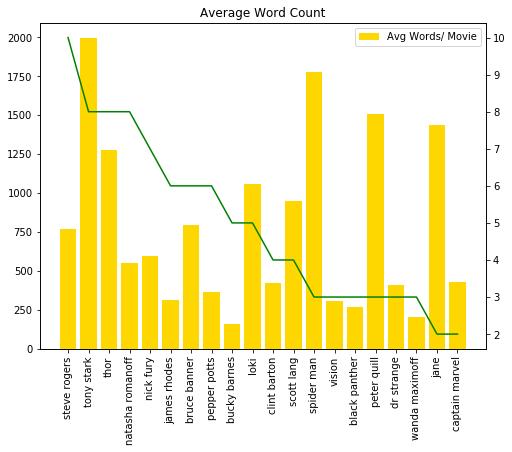

,Movie,Word Count,Avg Word Per Movie
Character,,,
steve rogers,10,7707,770.700000
tony stark,8,15938,1992.250000
thor,8,10204,1275.500000
natasha romanoff,8,4411,551.375000
nick fury,7,4169,595.571429
james rhodes,6,1893,315.500000
bruce banner,6,4763,793.833333
pepper potts,6,2201,366.833333
bucky barnes,5,812,162.400000


In [10]:
avg_plot(cleandf)

tony stark


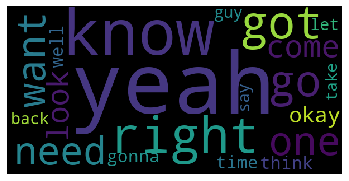

--------------
natasha romanoff


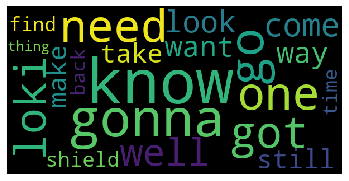

--------------
thor


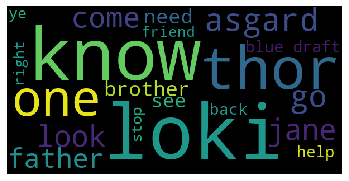

--------------
loki


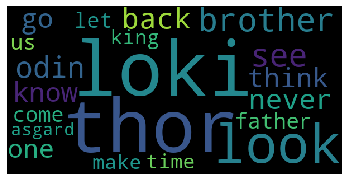

--------------
steve rogers


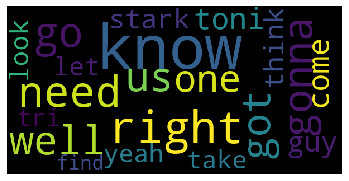

--------------
clint barton


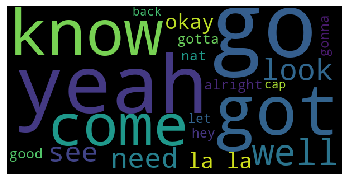

--------------
bruce banner


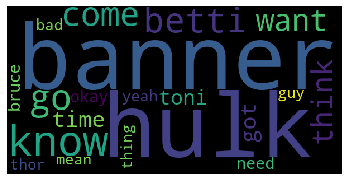

--------------
black panther


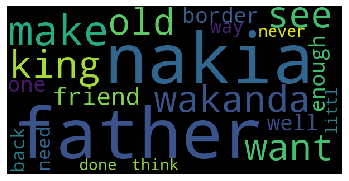

--------------
spider man


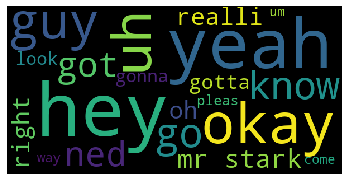

--------------
scott lang


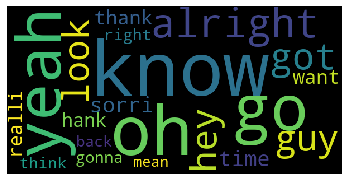

--------------
captain marvel


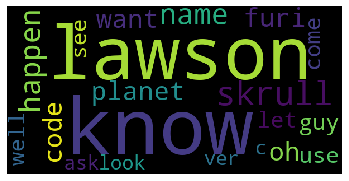

--------------
dr strange


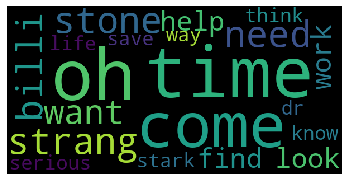

--------------
peter quill


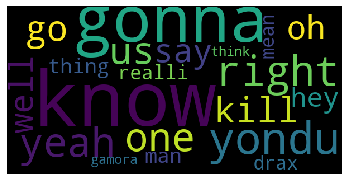

--------------
wanda maximoff


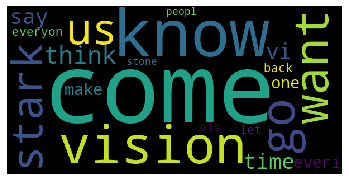

--------------
nick fury


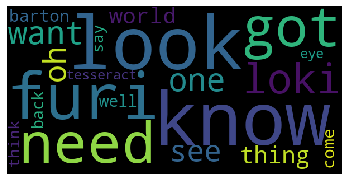

--------------
pepper potts


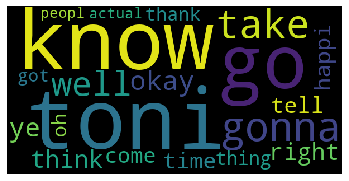

--------------
bucky barnes


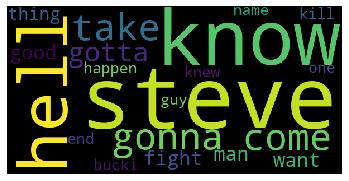

--------------
vision


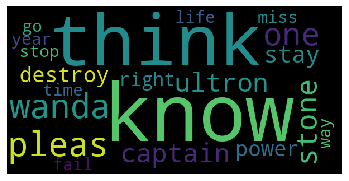

--------------
james rhodes


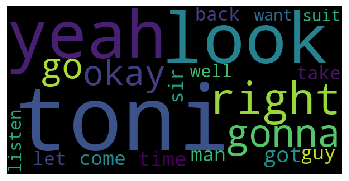

--------------
jane


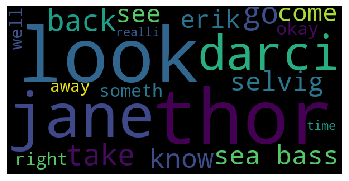

--------------


In [11]:
to_cloud(cleandf, 20)